In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


In [56]:
import sys
sys.path.append("../functions/")
#for data preprocessing
import Scripts_Data_Processing
import imp

imp.reload(Scripts_Data_Processing)
from Scripts_Data_Processing import *
#for model fit
import Scripts_LogRegModels_v2
imp.reload(Scripts_LogRegModels_v2)
from Scripts_LogRegModels_v2 import *

import NoBrainer_Analysis_AllinOne
imp.reload( NoBrainer_Analysis_AllinOne)
from  NoBrainer_Analysis_AllinOne import *

# gainloss load in single subjectdata + nobrainer

In [3]:
df_list = []
vp_perform_gainloss_list = []
vp_nb_gainloss_list = []
vp_list = ['06', '07', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '22'] #'23_2', '25_2', '26_2', '27_2', '28_2', '29', '30']
for vp in vp_list:
    path = os.path.join(os.getcwd(),'..','data','data_gainloss_logfiles','vp' + vp + '_gainloss_processed.csv')
    df = pd.read_csv(path, sep=",")
    #preprocess gainloss data
    df=preprocess_gainloss(df)
    #preprocess data
    df = preprocess(df)
    #store prepocessed data in list that contains data for all subjects (for later analysis)
    df_list.append(df)
    #create subset with unambiguous trials for no brainer analysis
    nb_df = drop_ambi_trials(df)
    #create variables indicating whether left or right was the better option
    better_choice_gainloss(nb_df)
    #indicate whether the better box was chosen
    nb_df = right_choice(nb_df)
    #only keep trials that are 'no brainers'
    nb_df = keep_nobrainers(nb_df)
    #calculate performance
    vp_perform_gainloss = ['vp' + vp, vp_perf(nb_df)]
    #store each vp performance in list
    vp_perform_gainloss_list.append(vp_perform_gainloss)
    #vp performance sectionwise
    vp_nb_gainloss = nb_df.groupby('section').mean().add_prefix('gainloss_')[['gainloss_choseBetter']]
    vp_nb_gainloss['MID'] = 'vp'+ vp
    vp_nb_gainloss_list.append(vp_nb_gainloss)
    
#make dataframe for nb performance
nobrainer_gainloss = pd.DataFrame(vp_perform_gainloss_list,columns=['MID','nbperf'])

#dataframe for single subject (last one) to try out code
gainloss_ls_df = df


../functions/NoBrainer_Analysis_AllinOne.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['left_better']=left_better
../functions/NoBrainer_Analysis_AllinOne.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['right_better']=right_better
../functions/NoBrainer_Analysis_AllinOne.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

In [4]:
vp_nb_gainloss_list

[         gainloss_choseBetter   MID
 section                            
 1                    0.888889  vp06
 2                    1.000000  vp06
 3                    0.928571  vp06,          gainloss_choseBetter   MID
 section                            
 1                    0.888889  vp07
 2                    1.000000  vp07
 3                    1.000000  vp07,          gainloss_choseBetter   MID
 section                            
 1                         1.0  vp10
 2                         1.0  vp10
 3                         1.0  vp10,          gainloss_choseBetter   MID
 section                            
 1                    0.888889  vp11
 2                    1.000000  vp11
 3                    1.000000  vp11,          gainloss_choseBetter   MID
 section                            
 1                    1.000000  vp12
 2                    0.909091  vp12
 3                    0.928571  vp12,          gainloss_choseBetter   MID
 section                            
 

## Create preprocessed dataframe with all vp

In [5]:
#Merge dataframe list to single dataframe. "inner": Just take columns which exist in all dataframes    
gainloss_df = pd.concat(df_list, ignore_index = True, join = 'inner')  

## Gain/Loss Model fit - individual subjects

In [6]:
param_sets_split = {}
param_sets_split['0'] = ['mag_diff','prob_diff']
param_sets_split['1'] = ['mag_diff','prob_diff','sqrt_prop_revealed']

In [24]:
vp_list = ['06','07','10', '12', '13', '15', '16', '17', '18', '19', '20', '22'] #'23_2', '25_2', '26_2', '27_2', '28_2', '29', '30']
resultnames = ['bic','aic','pseudoR2','pred_acc']
model_param_df = np.array(['','','',3.0])
model_summary_df = nobrainer_gainloss

for vp in vp_list:
    
    df = gainloss_df[gainloss_df.MID == 'vp' + vp]
    MID = 'vp' + vp
        
    for split in ['ambig_gain','ambig_loss','unambig_gain','unambig_loss']:
        #print(split)
        if 'unambig' in split:
            paramnum='0'
        else:
            paramnum='1'
        # Fit a model to the ambiguous gain trials 
        out = fit_model_split_amb_unamb_gain_loss(df, whichreturn= split, params=param_sets_split[paramnum],zscore=False)
        
    
        modelname = out['modelname']

        for result in resultnames:
            model_summary_df.loc[(model_summary_df.MID== 'vp' + vp),result+'_'+split]=out[result]

        params = out['params']
        for param in params.index:
            paramn = param.replace('_loss','')
            paramn = paramn.replace('_gain','')
            paramn = paramn.replace('_amb','')
            paramn = paramn.replace('_rl','')
            row = np.array([MID,paramn,split,params[param]])
            model_param_df=np.vstack((model_param_df,row))

model_param_df = pd.DataFrame(model_param_df,columns=['MID','parameter','split','beta'])
model_param_df.drop(0,inplace=True) #df.index[0]
model_param_df['beta']=model_param_df['beta'].astype('float')

print(out['aic'])
print(out['pred_acc'])
print(out['modelname'])
out['results'].summary()

73.2149550654
0.791666666667
model_split_unambig_lossmag_diff_prob_diff


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   72
Model:                          Logit   Df Residuals:                       69
Method:                           MLE   Df Model:                            2
Date:                Fri, 17 Nov 2017   Pseudo R-squ.:                  0.2771
Time:                        10:55:14   Log-Likelihood:                -33.607
converged:                       True   LL-Null:                       -46.491
                                        LLR p-value:                 2.539e-06
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
intercept             0.5567      0.303      1.835      0.067        -0.038     1.152
mag_diff_rl_loss      0.0289      0.012      2.344      0.019         0.005     0.053
prob_diff_rl_loss    -7.1660      1.853     -3.868      0.000       -10.797    -3.535
=====================================================================================
"""

In [25]:
model_param_df

,MID,parameter,split,beta
1,vp06,intercept,ambig_gain,-0.761985
2,vp06,mag_diff,ambig_gain,0.012441
3,vp06,prob_diff,ambig_gain,1.669512
4,vp06,sqrt_prop_revealed,ambig_gain,-1.877960
5,vp06,intercept,ambig_loss,-0.064936
6,vp06,mag_diff,ambig_loss,0.043434
7,vp06,prob_diff,ambig_loss,-0.463832
8,vp06,sqrt_prop_revealed,ambig_loss,0.291617
9,vp06,intercept,unambig_gain,0.195470
10,vp06,mag_diff,unambig_gain,0.022708


# Fit group of gain loss data
redundant to what I did before?

In [ ]:
for vp in vp_list:
    
    path = os.path.join(os.getcwd(),'..','data','data_gainloss_logfiles','vp' + vp + '_gainloss_processed.csv')
    df = pd.read_csv(path, sep=",")
    #preprocess gainloss data
    df=preprocess_gainloss(df)
    #preprocess data
    df = preprocess(df)

    for split in ['ambig_shock','ambig_gain','ambig_loss']:
        out = fit_model_split_amb_unamb_gain_loss(trial_table,
                                                  whichreturn=split,
                                                  params=param_sets_split['1'],zscore=False)
        modelname = out['modelname']
        print(modelname)
        print(out['params'])
        #pickle.dump(out,open(savefolder+
                #MID+'_'+modelname+'.p', "wb" ))

# shock load in single subjectdata + nobrainer

In [26]:
df_list = []
vp_list = ['06', '07', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '22', '23', '25', '26', '27', '28', '29', '30']
vp_perform_shock_list = []
vp_nb_shock_list = []
section_list = ['1', '2', '3']
for vp in vp_list:
    df = []
    for sec in section_list:
        path = os.path.join(os.getcwd(),'..','data','data_shock_logfiles','Expt1Pain_Behaviour_vp' + vp + '_' + sec + '.txt')
        df_dummy = pd.read_csv(path, sep="\t", skiprows = [0])
        df_dummy = df_dummy[:-1] #deletes last row of each section as it does not contain trial data
        df_dummy['MID'] = 'vp'+ vp
        df_dummy['section'] = sec
        df_dummy.columns = df_dummy.columns.str.replace(' ','')
        df.append(df_dummy)
    
    #create a df that contains data from all sections    
    df = pd.concat(df, ignore_index = True, join = 'inner')
    #preprocess shock data
    df = preprocess_shock(df)
    #preprocess data
    df = preprocess(df)
    #store prepocessed data in list that contains data for all subjects (for later analysis)
    df_list.append(df)
    #create subset with unambiguous trials for no brainer analysis
    nb_df = drop_ambi_trials(df)
    #create variables indicating whether left or right was the better option
    better_choice_shock(nb_df)
    #indicate whether the better box was chosen
    nb_df = right_choice(nb_df)
    #only keep trials that are 'no brainers'
    nb_df = keep_nobrainers(nb_df)
    #calculate performance
    vp_perform_shock = ['vp' + vp, vp_perf(nb_df)]
    #store each vp performance in list
    vp_perform_shock_list.append(vp_perform_shock)
    #vp performance sectionwise
    vp_nb_shock = nb_df.groupby('section').mean().add_prefix('shock_')[['shock_choseBetter']]
    vp_nb_shock['MID'] = 'vp'+ vp
    vp_nb_shock_list.append(vp_nb_shock)
    
#make dataframe for nb performance
nobrainer_shock = pd.DataFrame(vp_perform_shock_list,columns=['MID','nbperf'])

#dataframe for single subject (last one) to try out code
shock_ls_df = df

../functions/NoBrainer_Analysis_AllinOne.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['left_better']=lb
../functions/NoBrainer_Analysis_AllinOne.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['right_better']=rb


In [27]:
vp_nb_shock_list

[         shock_choseBetter   MID
 section                         
 1                      1.0  vp06
 2                      1.0  vp06
 3                      0.6  vp06,          shock_choseBetter   MID
 section                         
 1                      1.0  vp07
 2                      1.0  vp07
 3                      1.0  vp07,          shock_choseBetter   MID
 section                         
 1                      1.0  vp10
 2                      1.0  vp10
 3                      1.0  vp10,          shock_choseBetter   MID
 section                         
 1                      1.0  vp11
 2                      1.0  vp11
 3                      1.0  vp11,          shock_choseBetter   MID
 section                         
 1                      0.8  vp12
 2                      1.0  vp12
 3                      1.0  vp12,          shock_choseBetter   MID
 section                         
 1                      1.0  vp13
 2                      1.0  vp13
 3            

In [89]:
nb_df

,revealed_right,revealed_left,mag_left,mag_right,reaction_time,trial_number,resp,did_right_win,did_left_win,mag_outcome,...,mag_unambig,prob_x_ambig_bayes,prob_x_unambig,gain_or_loss_trial,revealed_x_ambig,revealed_o_ambig,left_better,right_better,choseBetter,noBrainer
1,1.0,1.0,11,16,1366,2.0,left,0.0,0.0,0.0,...,NaN,NaN,NaN,gain,NaN,NaN,True,False,True,True
2,1.0,1.0,63,13,1032,3.0,right,0.0,1.0,0.0,...,NaN,NaN,NaN,gain,NaN,NaN,False,True,True,True
4,1.0,1.0,11,2,1000,5.0,right,1.0,1.0,2.0,...,NaN,NaN,NaN,gain,NaN,NaN,False,True,True,True
22,1.0,1.0,8,9,899,23.0,left,1.0,1.0,8.0,...,NaN,NaN,NaN,gain,NaN,NaN,True,False,True,True
42,1.0,1.0,16,8,2900,43.0,right,1.0,1.0,8.0,...,NaN,NaN,NaN,gain,NaN,NaN,False,True,True,True
50,1.0,1.0,9,22,12581,1.0,left,0.0,0.0,0.0,...,NaN,NaN,NaN,gain,NaN,NaN,True,False,True,True
60,1.0,1.0,11,42,5348,11.0,left,1.0,1.0,11.0,...,NaN,NaN,NaN,gain,NaN,NaN,True,False,True,True
64,1.0,1.0,36,21,2766,15.0,right,1.0,1.0,21.0,...,NaN,NaN,NaN,gain,NaN,NaN,False,True,True,True
71,1.0,1.0,38,27,1100,22.0,right,0.0,0.0,0.0,...,NaN,NaN,NaN,gain,NaN,NaN,False,True,True,True
79,1.0,1.0,7,5,2766,30.0,right,1.0,1.0,5.0,...,NaN,NaN,NaN,gain,NaN,NaN,False,True,True,True


## Create preprocessed dataframe with all vp

In [28]:
#create complete df for shock condition with all vps        
shock_df = pd.concat(df_list, ignore_index = True, join = 'inner')

## Shock: Model fit


In [95]:
#out

In [105]:
vp_list = ['06', '07', '10', '11' ,'12', '13', '15', '16', '17', '18', '19', '20', '22', '23', '25', '26', '27', '28', '29', '30']
resultnames = ['bic','aic','pseudoR2','pred_acc'] ##'llr_pvalue' is missing bc did not work
model_param_df = np.array(['','','',3.0])
model_summary_df = nobrainer_shock

for vp in vp_list:
    
    df = shock_df[shock_df.MID == 'vp' + vp]
    MID = 'vp' + vp
        
    for split in ['ambig_shock','unambig_shock']:
        #print(split)
        if 'unambig' in split:
            paramnum='0'
        else:
            paramnum='1'
        # Fit a model to the ambiguous gain trials 
        out = fit_model_split_amb_unamb_gain_loss(df, whichreturn= split, params=param_sets_split[paramnum],zscore=True)
        
    
        modelname = out['modelname']

        for result in resultnames:
            model_summary_df.loc[(model_summary_df.MID== 'vp' + vp),result+'_'+split]=out[result]

        params = out['params']
        for param in params.index:
            paramn = param.replace('_shock','')
            paramn = paramn.replace('_amb','')
            paramn = paramn.replace('_rl','')
            row = np.array([MID,paramn,split,params[param]])
            model_param_df=np.vstack((model_param_df,row))

model_param_df = pd.DataFrame(model_param_df,columns=['MID','parameter','split','beta'])
model_param_df.drop(0,inplace=True) #df.index[0]
model_param_df['beta']=model_param_df['beta'].astype('float')

print(out['aic'])
print(out['pred_acc'])
print(out['modelname'])
out['results'].summary()
    
        
   

83.7804639334
0.722222222222
model_split_unambig_shockmag_diff_prob_diff


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   72
Model:                          Logit   Df Residuals:                       69
Method:                           MLE   Df Model:                            2
Date:                Fri, 17 Nov 2017   Pseudo R-squ.:                  0.2137
Time:                        12:44:13   Log-Likelihood:                -38.890
converged:                       True   LL-Null:                       -49.461
                                        LLR p-value:                 2.565e-05
=====================================================================================
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
intercept             0.3258      0.279      1.166      0.244        -0.222     0.874
mag_diff_rl_gain     -1.8564      0.535     -3.471      0.001        -2.905    -0.808
prob_diff_rl_gain    -1.6386      0.485     -3.376      0.001        -2.590    -0.687
=====================================================================================
"""

In [106]:
model_param_df.head()

,MID,parameter,split,beta
1,vp06,intercept,ambig_shock,-0.797270
2,vp06,mag_diff_gain,ambig_shock,-0.598574
3,vp06,prob_diff_gain,ambig_shock,-1.654646
4,vp06,sqrt_prop_revealed_gain,ambig_shock,-0.279013
5,vp06,intercept,unambig_shock,0.456900


In [107]:
# single bar graph for now 
import seaborn as sns
def plot_params(df,stripplot=False,outlier_cutoff=None,task='shock'):
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    matplotlib.rc("font", family="Times New Roman")
    sns.set_context('talk')
    sns.set_style('white',{'figure.facecolor':'white'})
    
    
    if outlier_cutoff is not None:
        df = df[(df.beta>-1.0*outlier_cutoff)&(df.beta<outlier_cutoff)]
    
    axis = sns.barplot(x='parameter',y='beta',data=df,color=[.4,.4,.4],ci=95,alpha=0.4)
    
    if stripplot:
        sns.stripplot(x="parameter", y="beta", data=df,color=[.4,.4,.4],alpha=0.2,jitter=True);

        
    current_palette=sns.color_palette()
    fig = plt.gcf()
    fig.suptitle('Model Parameters: '+modelname+' '+task,fontsize=12,x=0.55)
    sns.despine(ax=axis)
    axis.set_ylabel('beta (Prob Choose Right (except on Ambig))',fontsize=12)
    axis.set_xlabel('parameter',fontsize=12)
    axis.set_xticklabels(df.parameter.unique(),rotation=45,fontsize=12,ha='right')
    axis = plt.gca()
    
    # change name if needed
    xlabels = axis.get_xticklabels()

    fig.suptitle('')
    axis.set_title('Model Parameters (Across all Subjects)')
    axis.set_xlabel('Parameter')
    axis.set_ylabel('Group Regression Coefficients \n (Probability Choosing Ambig)')
    plt.tight_layout()
    return(fig)

In [110]:
#model_param_df.head()

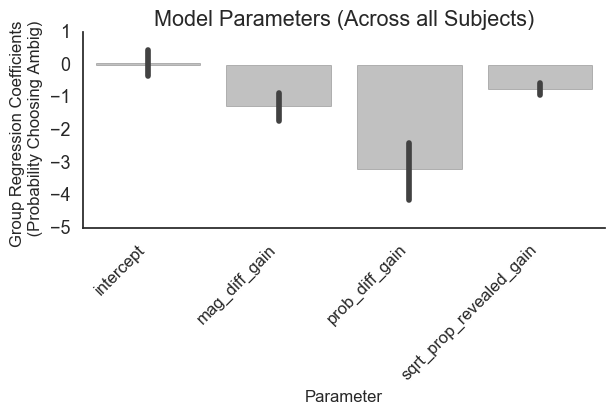

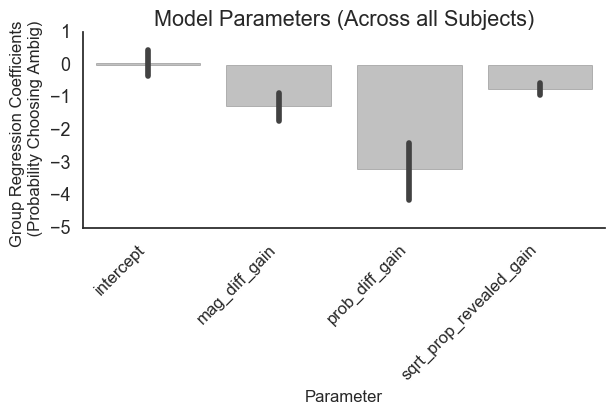

In [108]:
plot_params(model_param_df)

In [41]:
vp = '06'
resultnames = ['bic','aic','pseudoR2','pred_acc'] ##'llr_pvalue' is missing bc did not work
model_param_df = np.array(['','','',3.0])
model_summary_df = nobrainer_shock

    
df = shock_df[shock_df.MID == 'vp' + vp]
MID = 'vp' + vp
split = ['ambig_shock']
        










In [42]:
paramnum='1'


In [50]:
tt = df.copy()




In [57]:
out = fit_model_split_amb_unamb_gain_loss(df, whichreturn= split, params=param_sets_split[paramnum],zscore=False)
        
    


In [58]:
out


{'MID': 2999    vp30
 Name: MID, dtype: object,
 'X':     intercept  mag_diff_rl_gain  prob_diff_rl_gain
 0         1.0               5.0               0.16
 1         1.0             -50.0              -0.10
 2         1.0               0.0              -0.44
 3         1.0              -9.0              -0.20
 4         1.0              -4.0               0.04
 5         1.0              78.0              -0.40
 6         1.0              12.0              -0.36
 7         1.0             -62.0               0.46
 8         1.0              29.0              -0.12
 9         1.0              78.0              -0.46
 10        1.0               1.0               0.24
 11        1.0              -1.0               0.04
 12        1.0              17.0              -0.06
 13        1.0             -23.0               0.04
 14        1.0              18.0              -0.20
 15        1.0               4.0              -0.08
 16        1.0              -8.0              -0.36
 17        

In [59]:
modelname = out['modelname']

In [60]:
modelname

'model_split_unambig_shockmag_diff_prob_diff'

In [67]:
for result in resultnames:
    model_summary_df.loc[(model_summary_df.MID== 'vp' + vp),result+'_'+split]=out[result]

In [68]:
model_summary_df

,MID,nbperf,bic_ambig_gain,aic_ambig_gain,pseudoR2_ambig_gain,pred_acc_ambig_gain,bic_ambig_shock,aic_ambig_shock,pseudoR2_ambig_shock,pred_acc_ambig_shock,bic_unambig_shock,aic_unambig_shock,pseudoR2_unambig_shock,pred_acc_unambig_shock
0,vp06,0.882353,95.47375,86.046915,0.241858,0.769231,95.473750,86.046915,0.241858,0.769231,81.102651,74.272653,0.306312,0.736111
1,vp07,1.000000,NaN,NaN,NaN,NaN,86.566679,77.139844,0.312897,0.794872,34.029331,27.199332,0.779696,0.916667
2,vp10,1.000000,NaN,NaN,NaN,NaN,90.801093,81.374258,0.320141,0.794872,74.116739,67.286741,0.340877,0.833333
3,vp11,1.000000,NaN,NaN,NaN,NaN,80.852373,71.425538,0.383889,0.820513,39.708834,32.878836,0.730107,0.916667
4,vp12,0.941176,NaN,NaN,NaN,NaN,99.735390,90.308555,0.145199,0.730769,55.741402,48.911404,0.561250,0.847222
5,vp13,1.000000,NaN,NaN,NaN,NaN,90.583005,81.156170,0.307263,0.846154,59.582694,52.752695,0.524967,0.847222
6,vp15,0.941176,NaN,NaN,NaN,NaN,96.315185,86.888350,0.233685,0.756410,40.098799,33.268801,0.719091,0.875000
7,vp16,1.000000,NaN,NaN,NaN,NaN,52.957828,43.530992,0.654855,0.923077,42.632503,35.802505,0.695283,0.888889
8,vp17,1.000000,NaN,NaN,NaN,NaN,55.893867,46.467032,0.629909,0.858974,59.618113,52.788115,0.503226,0.875000
9,vp18,1.000000,NaN,NaN,NaN,NaN,104.501593,95.074758,0.188561,0.769231,99.744778,92.914780,0.124836,0.652778


In [69]:
params = out['params']

In [86]:
param




'prob_diff_rl_gain'

In [75]:
for param in params.index:
    paramn = param.replace('_loss','')
    paramn = paramn.replace('_gain','')
    paramn = paramn.replace('_amb','')
    paramn = paramn.replace('_rl','')
    row = np.array([MID,paramn,split,params[param]])
    model_param_df=np.vstack((model_param_df,row))

In [77]:
model_param_df

array([['vp06', 'sqrt_prop_revealed', 'ambig_shock', -0.0653493705726],
       ['vp06', 'sqrt_prop_revealed', 'ambig_shock', -0.0205211864267],
       ['vp06', 'sqrt_prop_revealed', 'ambig_shock', -4.4635241549],
       ['vp06', 'sqrt_prop_revealed', 'ambig_shock', -1.10020048543],
       ['vp06', 'sqrt_prop_revealed', 'unambig_shock', 0.0270672538549],
       ['vp06', 'sqrt_prop_revealed', 'unambig_shock', -0.0349025336055],
       ['vp06', 'sqrt_prop_revealed', 'unambig_shock', -7.89302468539],
       ['vp07', 'sqrt_prop_revealed', 'ambig_shock', 0.832177596959],
       ['vp07', 'sqrt_prop_revealed', 'ambig_shock', -0.0188200582779],
       ['vp07', 'sqrt_prop_revealed', 'ambig_shock', -5.04874758561],
       ['vp07', 'sqrt_prop_revealed', 'ambig_shock', -3.32392225755],
       ['vp07', 'sqrt_prop_revealed', 'unambig_shock', 0.789323413528],
       ['vp07', 'sqrt_prop_revealed', 'unambig_shock', -0.0859239713714],
       ['vp07', 'sqrt_prop_revealed', 'unambig_shock', -48.4129989673]

In [ ]:
model_param_df = pd.DataFrame(model_param_df,columns=['MID','parameter','split','beta'])
model_param_df.drop(0,inplace=True) #df.index[0]
model_param_df['beta']=model_param_df['beta'].astype('float')


In [39]:
params



intercept            0.073989
mag_diff_rl_gain    -0.046211
prob_diff_rl_gain   -5.418005
dtype: float64

In [35]:
model_param_df

,MID,parameter,split,beta
1,vp06,sqrt_prop_revealed,ambig_shock,-0.065349
2,vp06,sqrt_prop_revealed,ambig_shock,-0.020521
3,vp06,sqrt_prop_revealed,ambig_shock,-4.463524
4,vp06,sqrt_prop_revealed,ambig_shock,-1.100200
5,vp06,sqrt_prop_revealed,unambig_shock,0.027067
6,vp06,sqrt_prop_revealed,unambig_shock,-0.034903
7,vp06,sqrt_prop_revealed,unambig_shock,-7.893025
8,vp07,sqrt_prop_revealed,ambig_shock,0.832178
9,vp07,sqrt_prop_revealed,ambig_shock,-0.018820
10,vp07,sqrt_prop_revealed,ambig_shock,-5.048748


In [ ]:
# Fit a model to the unambiguous gain trials 
out = fit_model_split_amb_unamb_gain_loss(gainloss_ls_df,
                                          whichreturn='unambig_gain', # specifies which section of trials
                                          params=param_sets_split['0'], # specifies which model parameters to fit
                                          zscore=False)
print(out['aic'])
print(out['pred_acc'])
print(out['modelname'])
out['results'].summary()

In [ ]:
# Fit a model to the ambiguous shock trials 

out = fit_model_split_amb_unamb_gain_loss(df,
                                          whichreturn='ambig_shock', # specifies which section of trials
                                          params=param_sets_split['1'], # specifies which model parameters to fit
                                          zscore=False)
print(out['aic'])
print(out['pred_acc'])
print(out['modelname'])
out['results'].summary()

# Load subject fits and Plot Coefficients

See Example_analyze_emmas_fmri_shock_data

In [ ]:
nobrainer_shock

In [ ]:
nobrainer_gainloss

In [ ]:
vp_nb_gainloss_list